In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
%matplotlib inline



In [2]:
# Dataset Paths
train_dir = 'final_dataset/train'
test_dir = 'final_dataset/test'

# Image Size and Batch Size
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [3]:
# Get number of classes
NUM_CLASSES = len(train_generator.class_indices)

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False


In [4]:
# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
checkpoint = ModelCheckpoint('mobilenetv2_best_model.weights.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train model (Phase 1)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[checkpoint, reduce_lr]
)

c:\Users\jyoti\OneDrive\Desktop\Demo\Sign_language\sign_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2307 - loss: 1.7263
Epoch 1: val_accuracy improved from -inf to 0.40500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2329 - loss: 1.7223 - val_accuracy: 0.4050 - val_loss: 1.3788 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.4106 - loss: 1.4264
Epoch 2: val_accuracy improved from 0.40500 to 0.59500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 964ms/step - accuracy: 0.4116 - loss: 1.4240 - val_accuracy: 0.5950 - val_loss: 1.1591 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.5856 - loss: 1.1845
Epoch 3: val_accuracy improved from 0.59500 to 0.72500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 931ms/step - accuracy: 0.5865 - loss: 1.1825 - val_accuracy: 0.7250 - val_loss: 0.9796 - learning_rate: 1.0000e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.6711 - loss: 1.0283
Epoch 4: val_accuracy improved from 0.72500 to 0.84000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 936ms/step - accuracy: 0.6717 - loss: 1.0275 - val_accuracy: 0.8400 - val_loss: 0.8283 - learning_rate: 1.0000e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.7744 - loss: 0.8516
Epoch 5: val_accuracy improved from 0.84000 to 0.88000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7756 - loss: 0.8509 - val_accuracy: 0.8800 - val_loss: 0.7126 - learning_rate: 1.0000e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.8414 - loss: 0.7629
Epoch 6: val_accuracy improved from 0.88000 to 0.89500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8416 - loss: 0.7618 - val_accuracy: 0.8950 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.8582 - loss: 0.6905
Epoch 7: val_accuracy improved from 0.89500 to 0.92500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8585 - loss: 0.6897 - val_accuracy: 0.9250 - val_loss: 0.5413 - learning_rate: 1.0000e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8973 - loss: 0.5970 
Epoch 8: val_accuracy improved from 0.92500 to 0.94000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8972 - loss: 0.5967 - val_accuracy: 0.9400 - val_loss: 0.4780 - learning_rate: 1.0000e-04
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9279 - loss: 0.5435
Epoch 9: val_accuracy improved from 0.94000 to 0.95000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9276 - loss: 0.5432 - val_accuracy: 0.9500 - val_loss: 0.4297 - learning_rate: 1.0000e-04
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9172 - loss: 0.4989
Epoch 10: val_accuracy improved from 0.95000 to 0.96000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9170 - loss: 0.4990 - val_accuracy: 0.9600 - val_loss: 0.3849 - learning_rate: 1.0000e-04
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9155 - loss: 0.4880
Epoch 11: val_accuracy did not improve from 0.96000
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9158 - loss: 0.4871 - val_accuracy: 0.9600 - val_loss: 0.3529 - learning_rate: 1.0000e-04
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9285 - loss: 0.4126
Epoch 12: val_accuracy improved from 0.96000 to 0.96500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 992ms/step - accuracy: 0.9291 - loss: 0.4117 - val_accuracy: 0.9650 - val_loss: 0.3200 - learning_rate: 1.0000e-04
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9264 - loss: 0.4011
Epoch 13: val_accuracy did not improve from 0.96500
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 953ms/step - accuracy: 0.9270 - loss: 0.4005 - val_accuracy: 0.9650 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 14/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9515 - loss: 0.3477
Epoch 14: val_accuracy did not improve from 0.96500
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9513 - loss: 0.3478 - val_accuracy: 0.9650 - val_loss: 0.2720 - learning_rate: 1.0000e-04
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9493 - loss: 0.3395
Epoch 15: val_accuracy improved from 0.96500 to 0.97500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 948ms/step - accuracy: 0.9493 - loss: 0.3390 - val_accuracy: 0.9750 - val_loss: 0.2527 - learning_rate: 1.0000e-04
Epoch 16/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9517 - loss: 0.3199
Epoch 16: val_accuracy did not improve from 0.97500
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 933ms/step - accuracy: 0.9519 - loss: 0.3198 - val_accuracy: 0.9750 - val_loss: 0.2323 - learning_rate: 1.0000e-04
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9498 - loss: 0.2959
Epoch 17: val_accuracy improved from 0.97500 to 0.98000, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9501 - loss: 0.2956 - val_accuracy: 0.9800 - val_loss: 0.2198 - learning_rate: 1.0000e-04
Epoch 18/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.9636 - loss: 0.2682
Epoch 18: val_accuracy did not improve from 0.98000
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 958ms/step - accuracy: 0.9635 - loss: 0.2686 - val_accuracy: 0.9800 - val_loss: 0.2080 - learning_rate: 1.0000e-04
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9469 - loss: 0.2986  
Epoch 19: val_accuracy did not improve from 0.98000
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9469 - loss: 0.2980 - val_accuracy: 0.9750 - val_loss: 0.1953 - learning_rate: 1.0000e-04
Epoch 20/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9673 - loss: 0.2573
Epoch 20: val_accuracy improved from 0.98000 to 0.98500, saving model to mobilenetv2_best_model.weights.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9672 - loss: 0.2568 - val_accuracy: 0.9850 - val_loss: 0.1802 - learning_rate: 1.0000e-04


In [6]:
model.evaluate(test_generator)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9819 - loss: 0.1813


[0.18015341460704803, 0.9850000143051147]

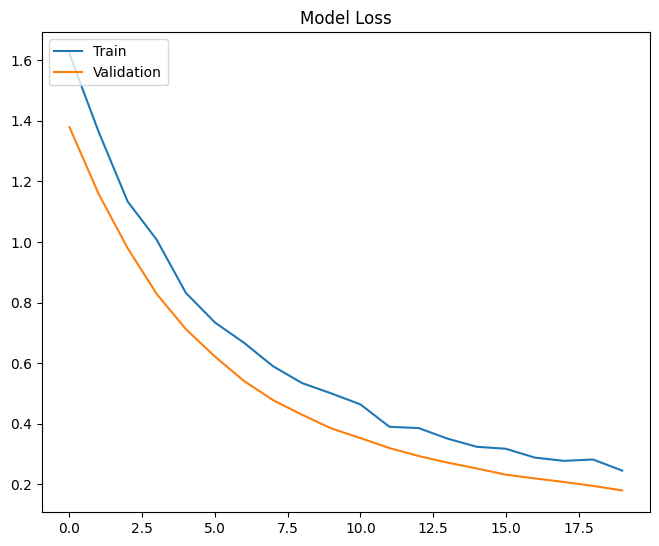

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

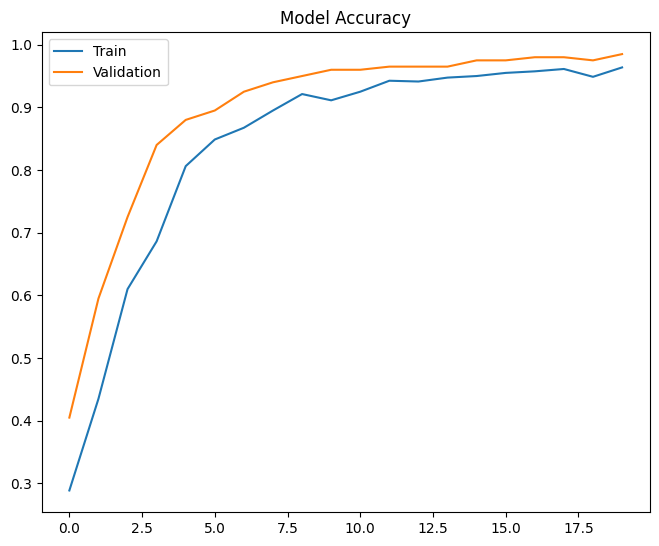

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

In [9]:
# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step


In [10]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))



Classification Report:

              precision    recall  f1-score   support

   good_luck       0.97      0.97      0.97        40
  i_love_you       0.98      1.00      0.99        40
          no       1.00      0.97      0.99        40
        stop       0.97      0.97      0.97        40
         yes       1.00      1.00      1.00        40

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.98       200
weighted avg       0.99      0.98      0.98       200



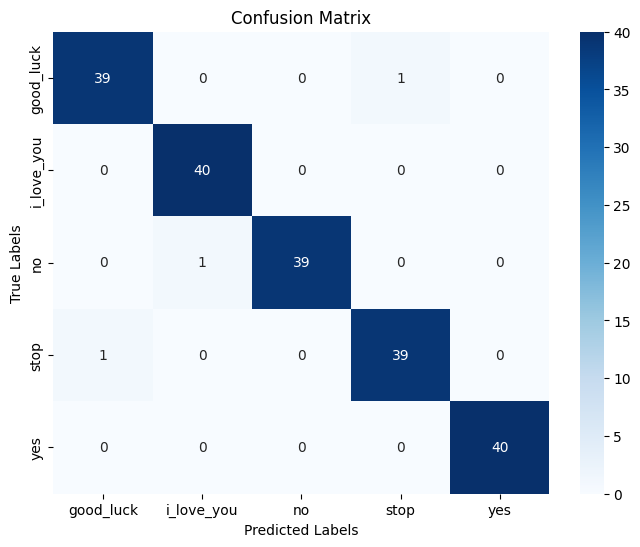

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save("sign_model.h5")